# Анализ индийского рынка подержанных автомобилей для импорта в Россию

## Описание проекта
В 2023 году компанией рассматривается возможность импорта подержанных автомобилей из Индии для перепродажи в России. 
Цель проекта — изучить структуру индийского рынка, проанализировать ценообразование и ключевые факторы спроса, чтобы определить перспективность этого направления.  

## **Данные**  
Датасет содержит **16 747 записей** о продажах автомобилей с следующими характеристиками:  

- **`full_name`** — марка, модель и год выпуска  
- **`resale_price`** — цена перепродажи (в lakhs/crores, 1 Lakh = 100 000 INR)  
- **`registered_year`** — год регистрации  
- **`engine_capacity`** — объём двигателя (см³)  
- **`insurance`** — тип страховки  
- **`transmission_type`** — тип КПП (автомат/механика)  
- **`kms_driven`** — пробег (км)  
- **`owner_type`** — количество владельцев  
- **`fuel_type`** — тип топлива (бензин/дизель)  
- **`max_power`** — мощность (л.с.)  
- **`seats`** — количество мест  
- **`mileage`** — расход топлива (км/л)  
- **`body_type`** — тип кузова (хэтчбек, седан и др.)  
- **`city`** — город продажи  

## **Цели исследования**  
- Выявить самые популярные и выгодные для закупки модели  
- Проанализировать зависимость цены от пробега, года выпуска и других факторов  
- Сравнить предложения в разных городах Индии  
- Оценить перспективы импорта в Россию  

## **Используемые технологии**  
- **Python** (Pandas, Matplotlib, Seaborn)  
- **Предобработка данных**   
- **Разведочный анализ (EDA)**  
- **Визуализация и статистический анализ**  

## **Ключевые выводы**  
- **Топ-модели по спросу и цене**  
- **Города с самыми выгодными предложениями**  
- **Влияние пробега и возраста на стоимость**  
- **Рекомендации по закупкам**  

Проект поможет понять, стоит ли рассматривать Индию как источник для импорта автомобилей.

##  Настройка рабочего окружения

In [191]:
import os
os.chdir("/Users/vladislavshcherakov/CSV")  # Смена директории
print("Рабочая директория:", os.getcwd())

# Отключаем научную нотацию для всех чисел
pd.set_option('display.float_format', '{:.2f}'.format)

Теперь рабочая директория: /Users/vladislavshcherakov/CSV


## Импорт библиотек

In [249]:
import math
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from warnings import filterwarnings
# Отключаем предупреждения 
filterwarnings('ignore')

# Увеличиваем лимит данных для Jupyter
pd.set_option('display.max_columns', None)
plt.rcParams['figure.max_open_warning'] = 50

# Загрузка и первичный осмотр данных
df = pd.read_csv('indian_car_sales_data.csv')
df.info()
display(df.head(3))  # Показать первые 3 записи
print(f"Всего записей: {len(df)}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16747 entries, 0 to 16746
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   full_name          16747 non-null  object 
 1   resale_price       16747 non-null  object 
 2   registered_year    16700 non-null  object 
 3   engine_capacity    16747 non-null  object 
 4   insurance          16740 non-null  object 
 5   transmission_type  16747 non-null  object 
 6   kms_driven         16747 non-null  object 
 7   owner_type         16706 non-null  object 
 8   fuel_type          16747 non-null  object 
 9   max_power          16747 non-null  object 
 10  seats              16746 non-null  float64
 11  mileage            16336 non-null  object 
 12  body_type          16747 non-null  object 
 13  city               16747 non-null  object 
dtypes: float64(1), object(13)
memory usage: 1.8+ MB


,full_name,resale_price,registered_year,engine_capacity,insurance,transmission_type,kms_driven,owner_type,fuel_type,max_power,seats,mileage,body_type,city
0,2017 Maruti Baleno 1.2 Alpha,вВє 5.45 Lakh_,2017,1197 cc,Third Party insurance,Manual,"40,000 Kms",First Owner,Petrol,83.1bhp,5.00,21.4 kmpl,Hatchback,Agra
1,2018 Tata Hexa XTA,вВє 10 Lakh_,2018,2179 cc,Third Party insurance,Automatic,"70,000 Kms",First Owner,Diesel,153.86bhp,7.00,17.6 kmpl,MUV,Agra
2,2015 Maruti Swift Dzire VXI,вВє 4.50 Lakh_,2015,1197 cc,Third Party insurance,Manual,"70,000 Kms",Second Owner,Petrol,83.14bhp,5.00,20.85 kmpl,Sedan,Agra


Всего записей: 16747


## 1. Оценка объема рынка подходящих автомобилей

Критерии отбора:

* Год выпуска: 2017 и новее (не старше 6 лет)
* Объем двигателя: ≤ 2000 см³

In [196]:
# Извлекаем год выпуска автомобиля из поля full_name (первые 4 символа)
# Пример: "2018 Hyundai Creta" -> берем "2018"
df['car_year'] = df['full_name'].apply(lambda x: x[:4])
# Преобразуем год в целочисленный тип
df['car_year'] = df['car_year'].astype('int')

# Извлекаем цифры из поля engine_capacity (объем двигателя)
# Пример: "1498 CC" -> находим "1498" с помощью регулярного выражения
df['engine_capacity_int'] = df['engine_capacity'].apply(lambda x: (re.findall(r'\d+', x))[0])
# Преобразуем объем двигателя в целочисленный тип
df['engine_capacity_int'] = df['engine_capacity_int'].astype('int')

# Фильтруем данные: оставляем только автомобили 2017 года выпуска и новее
filter_df_1 = df[df['car_year']>=2017]  
# Выводим количество оставшихся записей
print("Количество автомобилей 2017 года и новее:", filter_df_1.shape[0])

# Дополнительно фильтруем по объему двигателя (<= 2000 см³)
filter_df_2 = df[(df['car_year']>=2017) & (df['engine_capacity_int'] <= 2000)]
# Выводим количество записей после двойного фильтра
print("Количество автомобилей 2017+ года с объемом двигателя <= 2000 см³:", filter_df_2.shape[0])

# Считаем и выводим долю автомобилей с объемом <= 2000 см³ среди всех авто 2017+ года
print("Доля автомобилей с объемом <= 2000 см³:", round((filter_df_2.shape[0]/filter_df_1.shape[0]), 2))

Количество автомобилей 2017 года и новее: 9188
Количество автомобилей 2017+ года с объемом двигателя <= 2000 см³: 8478
Доля автомобилей с объемом <= 2000 см³: 0.92


### Ключевые выводы:

1. **Доминирование малолитражных двигателей**  
   Подавляющее большинство (92%) автомобилей имеют объем двигателя не более 2000 см³, что свидетельствует о:
   - Высоком спросе на экономичные модели
   - Популярности компактных городских автомобилей

2. **Структура автопарка**  
   - Лишь 8% автомобилей имеют двигатель >2000 см³
   - Это могут быть:
     * Премиальные модели
     * Внедорожники и кроссоверы
     * Коммерческий транспорт

3. **Импортные перспективы**  
   **При закупке автомобилей для российского рынка стоит учитывать:**
   - Основной ассортимент будет составлять малолитражные модели
   - Автомобили с большим объемом двигателя будут редкостью
   - Цены на модели >2000 см³ могут быть выше из-за ограниченного предложения

## 2. Анализ ценовой динамики автомобилей (2017-2023 гг.)

### Цель исследования
Изучить зависимость средней цены подержанных автомобилей от года выпуска (2017+) с конвертацией цен из индийских рупий в российские рубли для наглядности представления данных.

### Методология анализа
1. *Конвертация валюты*:
   - 1 Lakh (100 000 ₹) = 116 000 ₽
   - 1 Crore (10 000 000 ₹) = 11.6 млн ₽
   - Курс: 1 ₹ = 1.16 ₽
2. *Фильтрация данных*:
   - Отбор автомобилей 2017 года выпуска и новее
3. *Расчет показателей*:
   - Средняя цена по годам выпуска
   - Годовой прирост цен в %
### Результаты

* Таблица со средней ценой по годам выпуска и годовым приростом
* Визуализация (столбчатая диаграмма)


,Год выпуска,Средняя цена (млн ₽),Годовой прирост
0,2017,1.08,-
1,2018,1.14,+6%
2,2019,1.32,+16%
3,2020,1.53,+16%
4,2021,1.53,0%
5,2022,1.80,+18%
6,2023,2.85,+58%


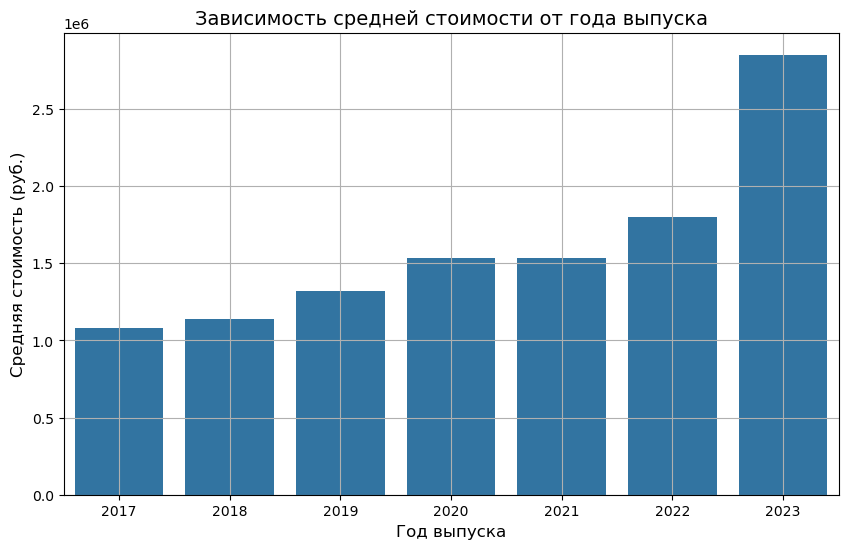

In [200]:
# Извлекаем числовое значение цены (второй элемент после разделения строки)
df['resale_price_1'] = df['resale_price'].apply(lambda x: x.split(' ')[1]).astype('float')

# Извлекаем валюту (третий элемент - 'Lakh_' или 'Crore')
df['resale_price_2'] = df['resale_price'].apply(lambda x: x.split(' ')[2])

# Конвертируем цены в рубли
for i in range(len(df)):
    if df['resale_price_2'][i] == 'Lakh_':
        # Если цена в Lakh (100,000 рупий), умножаем на 100,000 и курс 1.16
        df['resale_price_1'][i] = df['resale_price_1'][i] * 100000 * 1.16
    if df['resale_price_2'][i] == 'Crore':
        # Если цена в Crore (10,000,000 рупий), умножаем на 10,000,000 и курс 1.16
        df['resale_price_1'][i] = df['resale_price_1'][i] * 10_000_000 * 1.16

# Фильтруем данные: оставляем только автомобили 2017 года и новее
df_filtered = df[df['car_year'] >= 2017]

# Сбрасываем индексы после фильтрации (drop=1 означает удаление старого индекса)
df_filtered = df_filtered.reset_index(drop=1)

# Рассчитываем среднюю цену по годам
avg_price_by_year = df_filtered.groupby('car_year')['resale_price_1'].mean().reset_index()

#  Округляем среднюю цену до 2 знаков
df_gr_year_car = round(df_filtered.groupby('car_year')['resale_price_1'].agg(['mean']), 2)

# Создаем DataFrame из результатов
result = pd.DataFrame({
    'Средняя цена (млн ₽)': (df_gr_year_car['mean'] / 1_000_000).round(2)
})

# Добавляем годовой прирост
result['Годовой прирост'] = result['Средняя цена (млн ₽)'].pct_change().mul(100).round(0)
result['Годовой прирост'] = result['Годовой прирост'].apply(
    lambda x: '-' if pd.isna(x) else f"{'+' if x > 0 else ''}{int(x)}%"
)
# Восстанавливаем столбец с годами из индекса
result = result.reset_index()
result = result.rename(columns={'car_year': 'Год выпуска'})
# Выводим только нужные столбцы в правильном порядке
display(result[['Год выпуска', 'Средняя цена (млн ₽)', 'Годовой прирост']])


# Строим график зависимости цены от года выпуска
plt.figure(figsize=(10, 6))
sns.barplot(
    x='car_year', 
    y='resale_price_1', 
    data=df_filtered, 
    linewidth=2, 
    errorbar=None  # Убираем доверительные интервалы
)

# Настраиваем оформление графика
plt.title('Зависимость средней стоимости от года выпуска', fontsize=14)
plt.xlabel('Год выпуска', fontsize=12)
plt.ylabel('Средняя стоимость (руб.)', fontsize=12)
plt.grid(True)  
plt.show()

### Основные выводы:

1. **Рост цен**  
   - Средняя цена выросла с 1.08 млн руб. (2017) до 2.85 млн руб. (2023), (+164% за 6 лет)
   - Максимальный скачок в 2023 году (+58%)
2. **Динамика по годам**:
   - 2017-2020: Стабильный рост (+15-16% в год)
   - 2021: Стагнация (0%)
   - 2022-2023: Резкое ускорение (+18% и +58%)

## 3. Анализ показателей пробега

### Цель исследования:
Оценить распределение пробега на рынке подержанных автомобилей Индии и выявить долю автомобилей с чрезмерно высокими показателями пробега

### Методология анализа
1. **Предобработка данных**:
   - Извлечение числовых значений пробега из текстовых полей с помощью регулярных выражений
   - Преобразование строковых значений в числовой формат

2. **Фильтрация данных**:
   - Ограничение выборки автомобилями с пробегом ≤ 200,000 км
   - Сравнение размеров исходной и отфильтрованной выборок

3. **Визуализация распределения**:
   - Построение гистограммы
     
4. **Анализ результатов**:
   - Определение наиболее распространенных диапазонов пробега
   - Выявление аномальных значений и выбросов

Автомобилей после фильтрации: 9183
Всего автомобилей в выборке: 9188


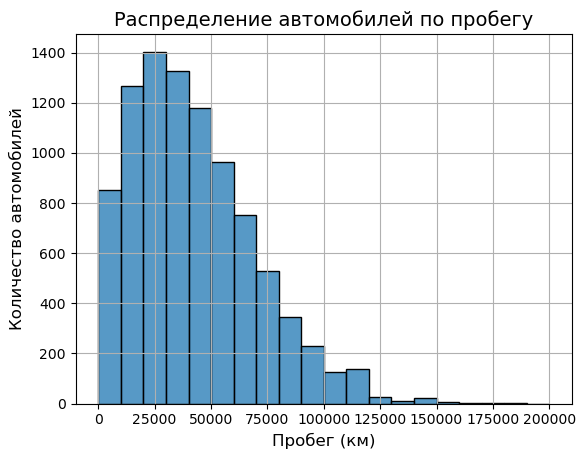

In [204]:
# Извлекаем числовое значение пробега из строки
# Пример: преобразуем "150,000 км" в 150000.0
df_filtered['kms_driven_1'] = df_filtered['kms_driven'].apply(
    lambda x: re.findall(r'\d+', x)  # Находим все числовые последовательности
)
df_filtered['kms_driven_1'] = df_filtered['kms_driven_1'].apply(
    lambda x: float(''.join(x))  # Объединяем цифры и преобразуем в число
)

# Фильтруем данные: оставляем только автомобили с пробегом до 200000 км
df_filtered_200 = df_filtered.query('kms_driven_1 <= 200000')

# Выводим количество автомобилей до и после фильтрации
print(f"Автомобилей после фильтрации: {df_filtered_200.shape[0]}")
print(f"Всего автомобилей в выборке: {df_filtered.shape[0]}")

# Строим гистограммы распределения пробега
sns.histplot(
    data=df_filtered_200,  # Используем отфильтрованные данные
    x='kms_driven_1',      # Ось X - пробег
    binwidth=10000,        # Ширина бина - 10000 км
    binrange=(0, 200001)   # Диапазон от 0 до 200000 км
)

# Настраиваем отображение графика
plt.title('Распределение автомобилей по пробегу', fontsize=14)
plt.xlabel('Пробег (км)', fontsize=12)
plt.ylabel('Количество автомобилей', fontsize=12)
plt.grid(True)   

# Отображаем графика
plt.show()

### Основные выводы:

- **Пик популярности (20-40 тыс. км)**  
  Наиболее массовый сегмент рынка:  
  - 20-30 тыс. км: 1,400 авто  
  - 30-40 тыс. км: 1,300 авто

- **Динамика снижения предложений**  
  Четкая отрицательная корреляция с ростом пробега:  

| Диапазон пробега | Количество авто |
|:-----------------|----------------:|
| 0-10k км        | 850            |
| 10-20k км       | 1,250          |
| 20-30k км       | 1,400          |
| 30-40k км       | 1,300          |
| 40-50k км       | 1,190          |
| 50-60k км       | 980            |
| 60-70k км       | 780            |
| 70-80k км       | 560            |

- **Редкие предложения**  
  Автомобили с большим пробегом встречаются значительно реже:  
  - 90-100k км: 210 авто  
  - 110-120k км: 160-170 авто  
  - 120+k км: единичные экземпляры (по 10 авто)

### Ключевые выводы

1. **Рынок ориентирован на "свежие" авто**  
   Более 60% предложений - автомобили с пробегом до 50 тыс. км

2. **Экспоненциальное уменьшение**  
   Каждые 10 тыс. км пробега уменьшают количество предложений на 20-30%

3. **Малый сегмент высокопробежных авто**  
   Автомобили >100k км составляют менее 5% рынка

4. **Данные свидетельствуют, что в Индии действительно преобладают автомобили с небольшим пробегом**

## 4. Анализ обновляемости модельного ряда подержанных автомобилей

### Цель:
Определить количество новых моделей автомобилей, появившихся на индийском рынке в 2022-2023 гг.
### Методология анализа:
1. **Извлечение названия модели автомобиля**
2. **Формирование выборок**:
   - Создание множества моделей 2022-2023 гг.
   - Создание множества моделей до 2021 г. включительно
3. **Сравнение модельных рядов**:
   - Вычисление разницы между множествами
   - Подсчет количества уникальных новых моделей

In [284]:
# Создаем новый столбец 'car_model', удаляя первые 4 символа (год) из поля 'full_name'
# Например: "2018 Tata Hexa XTA" -> "Tata Hexa XTA"
df_filtered['car_model'] = df_filtered['full_name'].apply(lambda x: x[4:])

# Показываем первые 3 строки для проверки корректности преобразования
display(df_filtered.head(3))

# Создаем множество уникальных моделей, которые продавались в 2022 или 2023 годах
# Используем множество для хранения только уникальных значений
set_22_23 = set(df_filtered.query('car_year == 2022 or car_year == 2023')['car_model'])

# Создаем множество уникальных моделей, которые продавались до 2021 года включительно
set_before_2021 = set(df_filtered.query('car_year <= 2021')['car_model'])

# Вычисляем количество моделей, которые есть в 2022-23 годах, но отсутствовали до 2021
# difference() возвращает элементы, которые есть в set_22_23, но нет в set_before_2021
new_models_count = len(set_22_23.difference(set_before_2021))

# Выводим результат - количество новых моделей, появившихся в 2022-2023 гг.
print(f"Количество новых моделей, появившихся в 2022-2023 гг.: {new_models_count}")

,full_name,resale_price,registered_year,engine_capacity,insurance,transmission_type,kms_driven,owner_type,fuel_type,max_power,seats,mileage,body_type,city,car_year,engine_capacity_int,resale_price_1,resale_price_2,kms_driven_1,car_model,max_power_1,index_car
0,2017 Maruti Baleno 1.2 Alpha,вВє 5.45 Lakh_,2017,1197 cc,Third Party insurance,Manual,"40,000 Kms",First Owner,Petrol,83.1bhp,5.00,21.4 kmpl,Hatchback,Agra,2017,1197,632200.00,Lakh_,40000.00,Maruti Baleno 1.2 Alpha,83.10,20.32
1,2018 Tata Hexa XTA,вВє 10 Lakh_,2018,2179 cc,Third Party insurance,Automatic,"70,000 Kms",First Owner,Diesel,153.86bhp,7.00,17.6 kmpl,MUV,Agra,2018,2179,1160000.00,Lakh_,70000.00,Tata Hexa XTA,153.86,26.44
2,2017 Tata Tiago 1.05 Revotorq XZ,вВє 3.60 Lakh_,2017,1047 cc,Third Party insurance,Manual,"1,20,000 Kms",First Owner,Diesel,69bhp,5.00,27.28 kmpl,Hatchback,Agra,2017,1047,417600.00,Lakh_,120000.00,Tata Tiago 1.05 Revotorq XZ,69.00,15.16


Количество новых моделей, появившихся в 2022-2023 гг.: 286


## Основные выводы по анализу обновления модельного ряда

**1. Высокий уровень обновления (286 новых моделей):**
   - Рынок демонстрирует активное обновление - за 2 года появилось 286 новых моделей, которых не было ранее

**2. Импортные перспективы в Россию:**
   - Широкий выбор современных моделей
   - Возможность закупать автомобили последних поколений
   - Потенциально более высокий спрос на новые модели

## 5. Оценка перспективности рынка через индекс качества автомобилей

### Цель:
Определить перспективность индийского рынка подержанных автомобилей на основе специального индекса качества.

### Методология анализа:

1. **Расчет индекса качества**:
   - Разработка формулы: 
     ```
     Индекс = (log₂(price) × √power) / log₂(kms/100)
     ```
     Где:
     - `price` - цена автомобиля (в рублях)
     - `power` - мощность двигателя (в л.с.)
     - `kms` - пробег (в километрах)

2. **Оценка рынка**:
   - Вычисление среднего значения индекса по всему рынку
   - Сравнение с пороговым значением (20)
     
3. **Интерпретация результатов**:
   - Выявление моделей с наилучшими показателями
   - Анализ корреляции индекса с другими параметрами

### Особенности формулы:
1. Логарифмирование цены уменьшает влияние абсолютной стоимости
2. Квадратный корень из мощности сглаживает разброс значений
3. Относительный пробег (км/100) обеспечивает более точную оценку состояния

In [232]:
# Преобразуем мощность в числовой формат
df_filtered['max_power_1'] = df_filtered['max_power'].astype('str')  # В строку
df_filtered['max_power_1'] = df_filtered['max_power_1'].apply(lambda x: re.findall(r'\d+', x))  # Извлекаем цифры
df_filtered['max_power_1'] = df_filtered['max_power_1'].apply(lambda x: '.'.join(x)).astype('float')  # В число

# Создаем функцию расчета индекса качества
def index_kwality(price, power, kms):
    return ((math.log2(price))*(math.sqrt(power))/(math.log2(kms/100)))  # Формула индекса

# Считаем индекс для каждого авто
df_filtered['index_car'] = 0  # Инициализация столбца
for i in range(len(df_filtered)):
    df_filtered['index_car'][i] = index_kwality(
        df_filtered['resale_price_1'][i],  # Цена
        df_filtered['max_power_1'][i],     # Мощность
        df_filtered['kms_driven_1'][i]     # Пробег
    )

# Вычисляем средний индекс
average_index = df_filtered['index_car'].mean()
average_index_rounded = round(average_index, 2)  # Округление

# Вывод результатов
display(df_filtered.head(3))  # Просмотр первых строк
print(f"\nСредний индекс качества: {average_index_rounded}")  # Итоговый результат

,full_name,resale_price,registered_year,engine_capacity,insurance,transmission_type,kms_driven,owner_type,fuel_type,max_power,seats,mileage,body_type,city,car_year,engine_capacity_int,resale_price_1,resale_price_2,kms_driven_1,car_model,max_power_1,index_car
0,2017 Maruti Baleno 1.2 Alpha,вВє 5.45 Lakh_,2017,1197 cc,Third Party insurance,Manual,"40,000 Kms",First Owner,Petrol,83.1bhp,5.00,21.4 kmpl,Hatchback,Agra,2017,1197,632200.00,Lakh_,40000.00,Maruti Baleno 1.2 Alpha,83.10,20.32
1,2018 Tata Hexa XTA,вВє 10 Lakh_,2018,2179 cc,Third Party insurance,Automatic,"70,000 Kms",First Owner,Diesel,153.86bhp,7.00,17.6 kmpl,MUV,Agra,2018,2179,1160000.00,Lakh_,70000.00,Tata Hexa XTA,153.86,26.44
2,2017 Tata Tiago 1.05 Revotorq XZ,вВє 3.60 Lakh_,2017,1047 cc,Third Party insurance,Manual,"1,20,000 Kms",First Owner,Diesel,69bhp,5.00,27.28 kmpl,Hatchback,Agra,2017,1047,417600.00,Lakh_,120000.00,Tata Tiago 1.05 Revotorq XZ,69.00,15.16



Средний индекс качества: 24.98


## Вывод по анализу индекса качества автомобилей

**Средний индекс качества:** 24.98

### Интерпретация результата:
- 📊 **Значение выше порогового (20)** - рынок оценивается как перспективный
- ✅ **Хорошее соотношение** цена/мощность/пробег у большинства автомобилей
- 🔍 **Рекомендуется** рассмотреть возможность импорта

### Рекомендации:
1. **Для закупок**:
   - Ориентироваться на автомобили с индексом >25 (выше среднего)
   - Особое внимание уделить топ-10 моделям по индексу

##  Топ-10 моделей по индексу качества

In [238]:
# Выводим топ-10 моделей по индексу качества
top_10 = (df_filtered[['car_model', 'index_car']]  # Берем название модели и индекс
          .sort_values('index_car', ascending=False)  # Сортируем по убыванию индекса
          .head(10)  # Берем топ-10
          .reset_index(drop=True))  # Сбрасываем старый индекс

# 2. Добавляем правильную нумерацию с 1
top_10.index = top_10.index + 1
top_10 = top_10.rename(columns={'full_name': 'Модель', 'index_car': 'Индекс качества'})

# 3. Выводим результат без лишних индексов
from IPython.display import display
display(top_10.style.hide(axis='index'))

car_model,Индекс качества
Mercedes-Benz E-Class AMG E 350d BSVI,257.998808
Mercedes-Benz AMG A 35 4MATIC BSVI,248.850604
Volvo XC40 B4 Ultimate BSVI,153.490504
Volvo XC40 B4 Ultimate BSVI,152.965147
Honda City ZX CVT,141.833087
Audi Q3 Technology BSVI,133.394079
BMW 2 Series 220i M Sport Pro BSVI,132.616741
Tata Altroz XZ Plus Dark Edition,109.340968
Maruti Jimny Alpha Dual Tone,108.175627
Mahindra Thar LX 4-Str Hard Top AT,99.654547
